In [1]:
class color:
   PURPLE, CYAN, DARKCYAN, BLUE = '\033[95m', '\033[96m', '\033[36m', '\033[94m'
   GREEN, YELLOW, RED, BOLD = '\033[92m', '\033[93m', '\033[91m','\033[1m'
   UNDERLINE, END = '\033[4m','\033[0m'

# Cleaning Data: reasonable results and time-interpretable grouping.
In order to get in second 40 touches per second you need to use all ten fingers on the screen, four times, or alternatively just your thumbs 20 times. In one second. Which is just impossible. Consider this: 
- the fastest finger tapping rate was set by Japanese musician Kaoru Watanabe in 2014. He achieved a rate of 13.36 taps per second.
- Prabhshish Singh (at 13) accurately typed letters from A to Z on a mobile phone in just 3 seconds and 44 milliseconds, as confirmed on August 29, 2022, making it about 7.5 touches each second. 

Not all users here must be world-record breakers, so for now statistical outliers will be treated as data spikes derived from device malfunction or improper handling of the screen.

We need to consider the **extreme touches**. If a value is an outlier it needs to be subsituted with the median. The median is a much more defensible measure because it has much less impact on the statistics than choosing any value, i.e. of the third quartile of the touch distribution. 

In [2]:
from scipy import stats
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [9]:
by_second_unclean = pd.read_csv("Processed Data/touch_sensor_unclean.csv") 
by_second_unclean = by_second_unclean.drop('Unnamed: 0', axis='columns')
print(f"N of observations: {by_second_unclean.shape[0]:,}")
by_second_unclean.head(3)

N of observations: 19,859,174


,userid,day,timestamp,touches
0,1,2020-11-22,2020-11-22 00:00:00,6
1,1,2020-11-22,2020-11-22 00:00:03,1
2,1,2020-11-22,2020-11-22 00:00:06,2


A brief, general look at statistical outliers:

At least one outlier belongs to: 128 out of 201 of the users
Outliers are 355,932 out of 19,859,174 = 1.79%
touches
1      4266857
2      4127960
3      2299172
4      1728830
5      1200586
        ...   
960          1
966          1
983          1
985          1
998          1
Name: count, Length: 565, dtype: int64


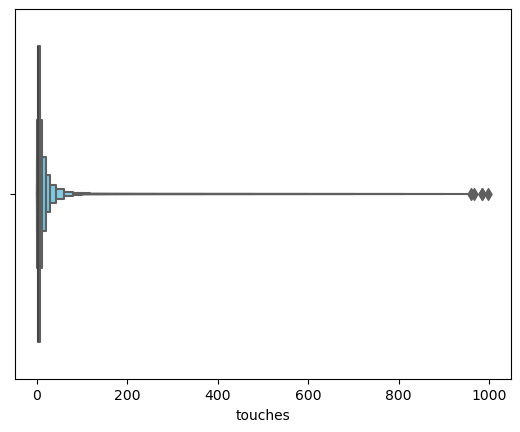

In [10]:
z = np.abs(stats.zscore(by_second_unclean['touches']))
threshold = 3  #this is the typical chosen score for outliers
outliers = by_second_unclean[z > threshold]
#print("User IDs with outlier observations:\n", np.sort(outliers.userid.unique()))
print(f"At least one outlier belongs to: {outliers.userid.unique().shape[0]:,} out of {by_second_unclean.userid.unique().shape[0]:,} of the users")    #should be 1.79%
print(color.BOLD + f"Outliers are {outliers.shape[0]:,} out of {by_second_unclean.shape[0]:,} = {str(round(outliers.shape[0]/ by_second_unclean.shape[0]*100, 2))}%" + color.END)
print(by_second_unclean.touches.value_counts().sort_index())
sns.boxenplot(data = by_second_unclean, x=by_second_unclean.touches, color='#4CC9F0')
plt.show()

Now, treating those statistical outliers. **Run the following cell only once.**

In [11]:
# Replacing the 1.79% outliers for the data that has seconds as units with their median
median, std = by_second_unclean['touches'].median(), by_second_unclean['touches'].std()
outliers = (by_second_unclean['touches'] - median).abs() > std

by_second = by_second_unclean    
by_second.touches[outliers] = np.nan
by_second['touches'].fillna(median, inplace=True)   # by_second is the cleaner version

by_second.head(3)

/tmp/ipykernel_35598/1054526867.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_second.touches[outliers] = np.nan


,userid,day,timestamp,touches
0,1,2020-11-22,2020-11-22 00:00:00,6.0
1,1,2020-11-22,2020-11-22 00:00:03,1.0
2,1,2020-11-22,2020-11-22 00:00:06,2.0


In [13]:
by_second.to_csv('Processed Data/by_second_clean.csv')

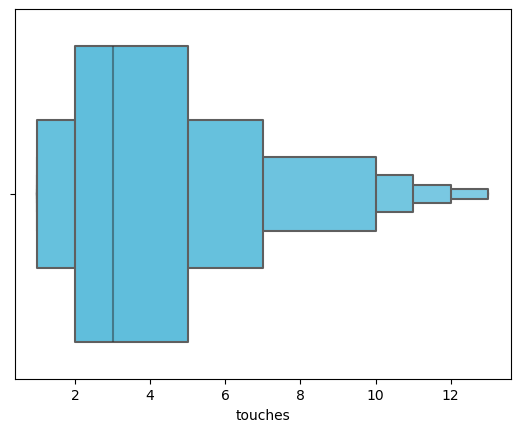

In [12]:
sns.boxenplot(data = by_second, x=by_second.touches, color='#4CC9F0', 
              k_depth='trustworthy', trust_alpha=0.05)
plt.show()

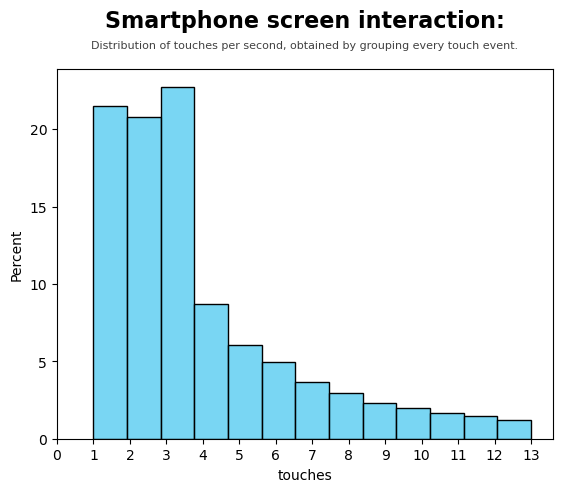

In [15]:
g = sns.histplot(data = by_second, x=by_second.touches, stat='percent', color='#4CC9F0', bins=13)
g.text(x=0.5, y=1.1, s='Smartphone screen interaction per second:', fontsize=16, weight='bold', ha='center', va='bottom', transform=g.transAxes)
g.text(x=0.5, y=1.05, s='Distribution of touches per second, obtained by grouping every touch event.', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
g.set_xticks(range(14))
g.set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.show()

## To recap:
Every touch events was tied to a second. Then, each row of the dataframe would represent how many times one user touched their phone in one second. 
Now, spikes in the data (defined as the statistical outliers) have been treated and moved to the median of the distribution. 

## What will be done in the next sections:
- Cleaning data from lacking / dropout users
- Applying the concept of circadian time on days and hours

Very obviously, only the users that gave enough days to be useful the experiment should be considered. Below I plotted separately the distribution of events (seconds in which there is at least one touch) over the days in which data was collected. 

Ideally, the observation should regard two weeks, **starting from when most users logged** and **ending when they start to drop out massively**. Personally, I choose the two week period starting from 2020/11/12 and ending 2020/11/26. 
# Distribution: count of events (grouped by second) registered between the start and end of observation period
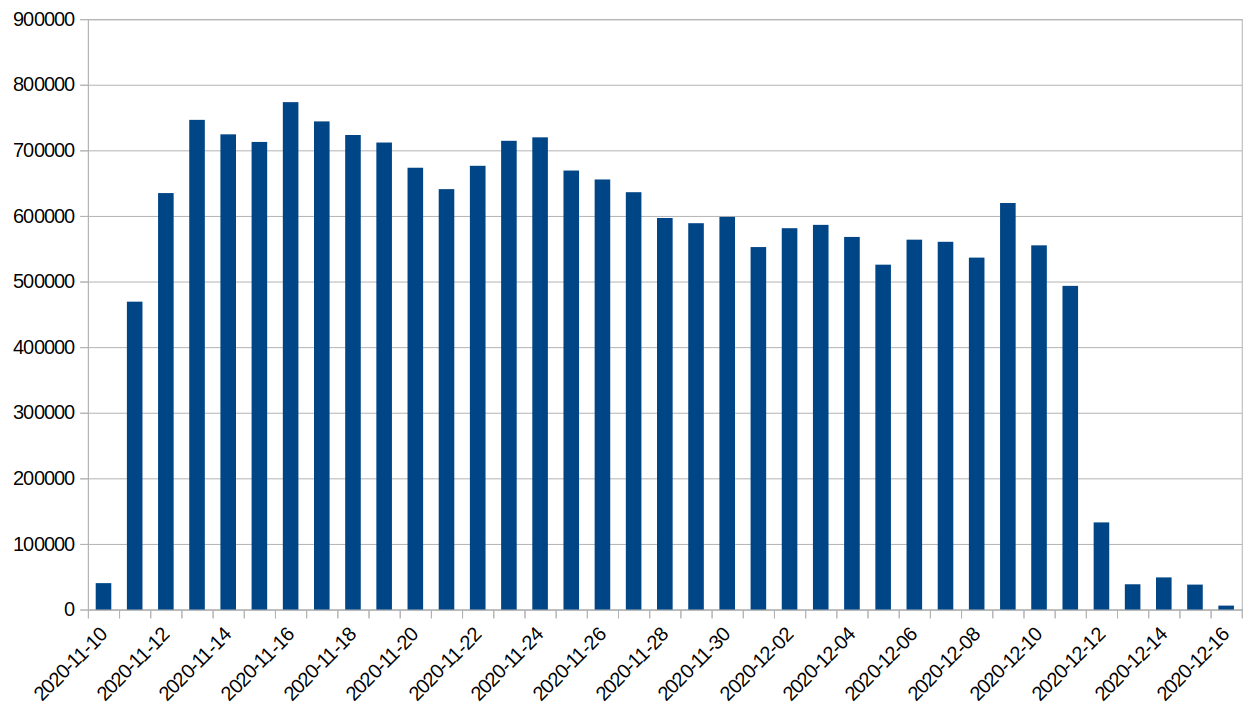

What also needs to be done is to mark each row as belonging to a specific circadian day - differently from clock time, but not independently. 
The logic is exemplified as follows: when one user is scrolling their phone from 23:59:00 until 00:20:10 and then went to sleep and did not wake up until the morning after, and we want to group per day (for visualization and analysis purposes) the times they were scrolling, we should count everything that happened from 00:00:00 to 00:20:10 and consider it part of the previous day. This logic should seamlessy apply to the many students that don't stop their day before 24:00:00.  

According to prof. Bison and the WeNet team, an ideal breakpoint for counting circadian day activities is between 04:30:00 and 05:00:00, because at that time everyone usually has finished their day and the next will start in a few minutes or hours. 

In [3]:
by_second = pd.read_csv('Processed Data/by_second_clean.csv')
timestamp, day = pd.to_datetime(by_second.timestamp, yearfirst=True), pd.to_datetime(by_second.day, yearfirst=True)
by_second.timestamp, by_second.day = timestamp, day
by_second = by_second.drop('Unnamed: 0',axis='columns')
%time

In [5]:
by_second

,userid,day,timestamp,touches
0,1,2020-11-22,2020-11-22 00:00:00,6.0
1,1,2020-11-22,2020-11-22 00:00:03,1.0
2,1,2020-11-22,2020-11-22 00:00:06,2.0
3,1,2020-11-22,2020-11-22 00:00:53,2.0
4,1,2020-11-22,2020-11-22 00:00:54,1.0
...,...,...,...,...
19859169,208,2020-11-24,2020-11-24 23:06:12,2.0
19859170,208,2020-11-24,2020-11-24 23:06:13,1.0
19859171,208,2020-11-24,2020-11-24 23:06:14,2.0
19859172,208,2020-11-24,2020-11-24 23:06:18,1.0


In [85]:
IDs=by_second.userid.unique()
IDs.sort()

#data structure:
'''
{id: [2020-11-12, 2020-11,13, 2020-11-14,...]}   #for every ID, there is a list of days in which there is at least one observation from them. 
'''
user_activity = dict()
for ID in tqdm(IDs):
    id_act = by_second[by_second.userid == ID]
    # adding to the dictionary
    user_activity[f'{ID}'] = pd.Series(id_act.day.unique()).sort_values()
print("Done!")

100%|█████████████████████████████████████████| 201/201 [00:06<00:00, 29.64it/s]

Done!


I will create a small dataset that categorizes each user into an 'always active', 'almost two weeks' active and 'less than two weeks' which means less than 12 days. 

In [117]:
def gantt_data_org(k, v):
    
    #v is the list of days; it's best if it's a consecutive 14 days (regardless of when they start)
    
    tot = (pd.to_datetime(v[-1]) - pd.to_datetime(v[0])).days
    if tot:
        start, end = v[0], v[-1]
        for i in range(len(v)-1):
            v[i]  #current
            v[i+1] #next
            difference = (pd.to_datetime(v[i+1]) - pd.to_datetime(v[i])).days
            if difference >= 2:    # if there is more than one day of difference it means that there was one 
                                   # day in the data with no observations
                consecutive = False
                break
            else:
                consecutive = True
            
    else:
        tot = np.nan
        start, end = np.nan, np.nan 
        consecutive = np.nan
    return pd.DataFrame([[k, start, end, tot, consecutive]], 
                        columns=['userid', 'start', 'finish', 'tot', 'cons'])

gantt_data_org(1, ["2020-11-12", "2020-11-13", "2020-11-14", "2020-11-15", "2020-11-16", 
                   "2020-11-17",   "2020-11-18", "2020-11-19", "2020-11-25"])


,userid,start,finish,tot,cons
0,1,2020-11-12,2020-11-25,13,False


In [118]:
gantt_data = pd.DataFrame(columns=["userid", "start", "finish", "tot", "cons"])
for ID, days in user_activity.items():
    res = gantt_data_org(ID, list(days))
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)

In [133]:
gantt_data

,userid,start,finish,tot,cons
0,1,2020-11-12,2020-12-12,30,True
1,2,2020-11-10,2020-11-30,20,True
2,3,2020-11-11,2020-12-11,30,True
3,4,2020-11-11,2020-12-09,28,True
4,5,2020-11-11,2020-12-12,31,True
...,...,...,...,...,...
196,260,2020-11-12,2020-12-11,29,True
197,261,2020-11-12,2020-12-06,24,False
198,262,2020-11-11,2020-12-12,31,True
199,264,2020-11-10,2020-12-12,32,True


In [161]:
same_n_days = gantt_data.groupby(["tot", 'userid']).head()
more_than_14 = sum(same_n_days.sort_values(by="tot")[same_n_days.cons == True].tot >= 14)
less_than_14 = sum(same_n_days.sort_values(by="tot").tot < 14) + gantt_data.shape[0] - same_n_days.shape[0]


/tmp/ipykernel_57238/1656350164.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  more_than_14 = sum(same_n_days.sort_values(by="tot")[same_n_days.cons == True].tot >= 14)


In [162]:
print(f"Active for 14 consecutive days or more: {color.BOLD}{more_than_14}{color.END}")
print(f"Less than two weeks: {color.BOLD}{less_than_14}{color.END}")
print(f"total: {more_than_14 + less_than_14}")
print()

Active for 14 consecutive days or more: 127
Less than two weeks: 39
total: 166



There are 46 users who are not eligible for my analysis and are considered dropped out, but 146 users who did well. Jury still out on what to do with "almost two weeks" users.

In [83]:
dropouts = gantt_data[gantt_data.category == 'less than two weeks'].userid  #IDs of dropouts
dropouts

6        7
12      14
20      24
21      25
23      27
31      35
32      36
33      37
34      41
36      43
38      46
40      49
42      51
43      52
52      67
53      68
61      82
65      86
70      93
75     101
77     106
80     110
81     112
85     116
86     117
90     122
91     123
93     125
109    149
113    156
121    164
126    172
131    179
132    180
134    184
138    189
143    195
147    199
152    205
163    220
169    228
175    234
176    235
183    242
186    245
197    261
Name: userid, dtype: object

In [81]:
# df_bs means Dataframe by second (without dropouts), df_ds means Dataframe for dropouts
df_bs = by_second[~by_second.userid.isin(dropouts)]
df_ds = by_second[by_second.userid.isin(dropouts)]

In [84]:
by_second[by_second.userid==261]

,userid,day,timestamp,touches
1494360,261,2020-11-27,2020-11-27 07:26:48,1.0
1494361,261,2020-11-27,2020-11-27 07:26:49,1.0
1494362,261,2020-11-27,2020-11-27 07:26:53,1.0
1494363,261,2020-11-27,2020-11-27 07:26:58,1.0
1494364,261,2020-11-27,2020-11-27 07:27:01,1.0
...,...,...,...,...
15734186,261,2020-11-15,2020-11-15 22:40:52,1.0
15734187,261,2020-11-15,2020-11-15 22:40:53,2.0
15734188,261,2020-11-15,2020-11-15 22:40:54,2.0
15734189,261,2020-11-15,2020-11-15 22:40:57,2.0


In [82]:
df_ds

,userid,day,timestamp,touches


In [20]:
sum_gantt = gantt_data
sum_gantt['days_to_start'] = (sum_gantt['start'] - sum_gantt['start'].min()).dt.days
sum_gantt['days_to_end'] = (sum_gantt['finish'] - sum_gantt['start'].min()).dt.days
sum_gantt['period_duration'] = sum_gantt['days_to_end'] - sum_gantt['days_to_start'] + 1

    userid             category      start     finish  days_to_start  \
0        1        always active 2020-11-12 2020-11-26            0.0   
1        2        always active 2020-11-12 2020-11-26            0.0   
2        3        always active 2020-11-12 2020-11-26            0.0   
3        4        always active 2020-11-12 2020-11-26            0.0   
4        5        always active 2020-11-12 2020-11-26            0.0   
..     ...                  ...        ...        ...            ...   
196    260        always active 2020-11-12 2020-11-26            0.0   
197    261  less than two weeks        NaT        NaT            NaN   
198    262        always active 2020-11-12 2020-11-26            0.0   
199    264        always active 2020-11-12 2020-11-26            0.0   
200    265        always active 2020-11-12 2020-11-25            0.0   

     days_to_end  period_duration  
0           14.0             15.0  
1           14.0             15.0  
2           14.0           

<BarContainer object of 201 artists>

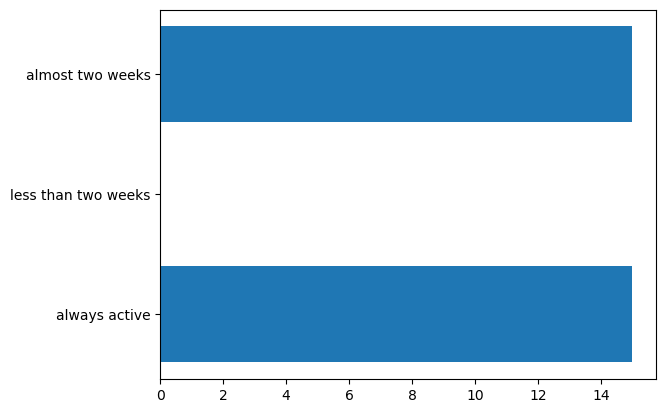

In [22]:
print(sum_gantt)
plt.barh(y=sum_gantt['category'], width=sum_gantt['period_duration'], left=sum_gantt['days_to_start'])


In [14]:
active_days = user_activity.count()